In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import mplcyberpunk
plt.style.use('cyberpunk')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
dataset = pd.read_csv('Retail_sales_of_electricity_United_States_monthly.csv', header=4)
dataset.drop_duplicates(subset='Month', inplace=True)
dataset.set_index('Month', inplace=True)
dataset.index = pd.to_datetime(dataset.index, format='%b %Y')
dataset.dropna(inplace=True)
dataset.rename(columns={'all sectors million kilowatthours': 'All sectors [MkWh]',
                        'residential million kilowatthours': 'Residential [MkWh]',
                        'commercial million kilowatthours': 'Commercial [MkWh]',
                        'industrial million kilowatthours': 'Industrial [MkWh]'}, 
               inplace=True)
dataset = dataset.iloc[::-1]
dataset

,All sectors [MkWh],Residential [MkWh],Commercial [MkWh],Industrial [MkWh]
Month,,,,
2000-12-01,310816.06880,127065.78354,90825.27235,83477.36044
2001-01-01,272334.73804,99877.67304,81466.85778,82248.23193
2001-02-01,269298.40142,92804.58576,84064.24963,83521.51752
2001-03-01,254390.93545,82453.78260,81060.53414,82253.07658
2001-04-01,264490.49166,81731.15295,87470.74429,86096.58080
...,...,...,...,...
2022-06-01,389214.17473,164276.57789,133951.71136,90419.84289
2022-07-01,389626.28230,160271.46691,135675.95261,93143.14117
2022-08-01,340543.84071,129241.31830,124195.27519,86549.52268


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 2000-12-01 to 2022-10-01
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   All sectors [MkWh]  263 non-null    float64
 1   Residential [MkWh]  263 non-null    float64
 2   Commercial [MkWh]   263 non-null    float64
 3   Industrial [MkWh]   263 non-null    float64
dtypes: float64(4)
memory usage: 10.3 KB


In [4]:
dataset.describe()

,All sectors [MkWh],Residential [MkWh],Commercial [MkWh],Industrial [MkWh]
count,263.000000,263.000000,263.000000,263.000000
mean,308191.403270,115377.005248,108599.699097,82822.510946
std,31290.602971,19931.067921,11488.055202,4138.620648
min,253033.663620,80806.694090,80951.199920,71358.009430
25%,285672.200230,98159.420355,101579.837245,79876.591070
50%,301852.693150,114232.804460,107473.487070,82979.766390
75%,328162.475465,129085.711270,115959.382180,85780.474630
max,389626.282300,167108.141570,135675.952610,93143.141170


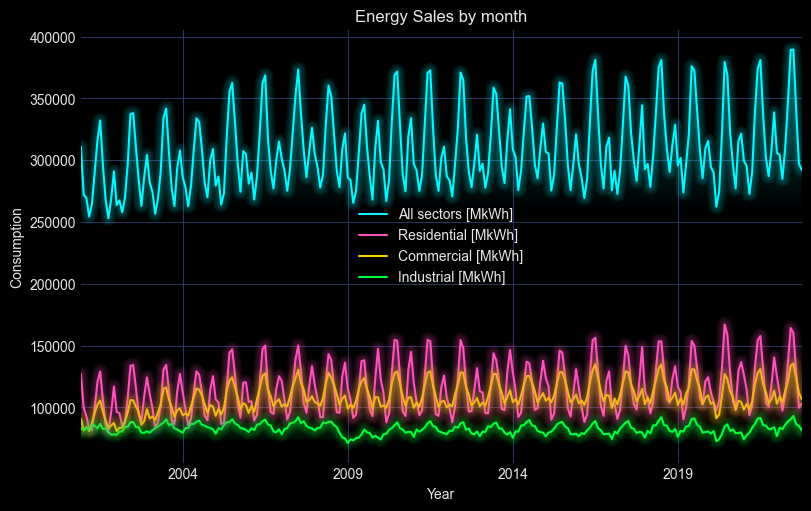

In [5]:
fig1, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
dataset.plot(ax=ax1)
ax1.set(title='Energy Sales by month', xlabel='Year', ylabel='Consumption')
ax1.set_facecolor('black')
fig1.set_facecolor('black')
mplcyberpunk.make_lines_glow(ax=ax1)
mplcyberpunk.add_gradient_fill(ax=ax1, alpha_gradientglow=0.3)
fig1.savefig('./images/HoltWintersMethod1.png');

## Splitting the data

In [6]:
split_ratio = 0.8
split_part = int(len(dataset) * split_ratio)
data_train = dataset.iloc[:split_part]
data_test = dataset.iloc[split_part:]
colors = ['cyan', 'violet', 'lime', 'red', 'blue']

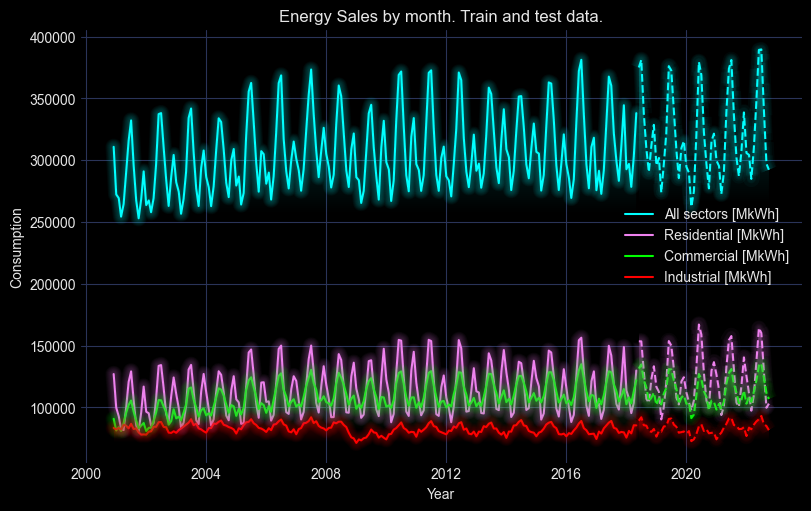

In [7]:
fig2, ax2 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
for color, column_name in zip(colors, dataset.columns):
    ax2.plot(data_train.index, data_train[column_name], color=color, label=column_name)
    ax2.plot(data_test.index, data_test[column_name], color=color, linestyle='--')
ax2.set(title='Energy Sales by month. Train and test data.',
        xlabel='Year', ylabel='Consumption')
ax2.legend()
ax2.set_facecolor('black')
fig2.set_facecolor('black')
mplcyberpunk.make_lines_glow(ax=ax2)
mplcyberpunk.add_gradient_fill(ax=ax2, alpha_gradientglow=0.3)
fig2.savefig('./images/HoltWintersMethod2.png');

## Predicting the data

In [8]:
holtWinterModel = ExponentialSmoothing(data_train['All sectors [MkWh]'], trend='add', 
                                       seasonal='add', seasonal_periods=12, freq='MS').fit()
holtWinterPrediction = holtWinterModel.forecast(len(data_test)).rename('PREDICT')

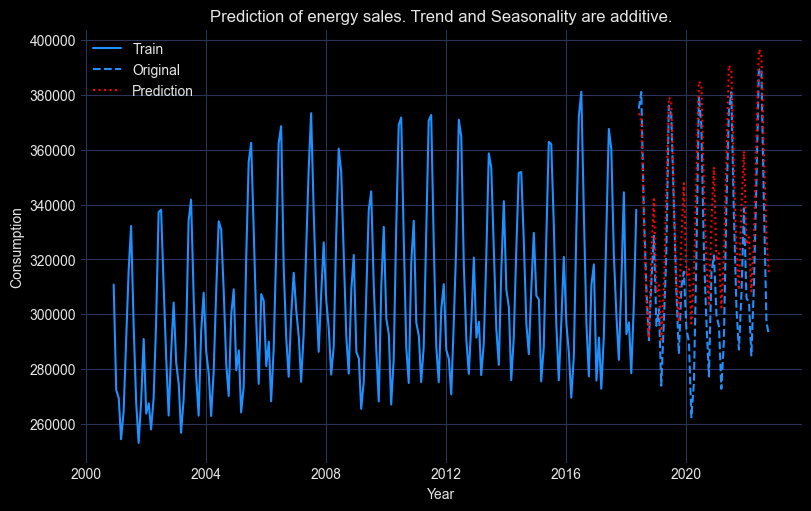

In [9]:
fig3, ax3 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
ax3.plot(data_train.index, data_train['All sectors [MkWh]'], label='Train', color='dodgerblue')
ax3.plot(data_test.index, data_test['All sectors [MkWh]'], 
         label='Original', color='dodgerblue', linestyle='--')
ax3.plot(data_test.index, holtWinterPrediction, label='Prediction', color='red', linestyle=':')
ax3.legend()
ax3.set(title='Prediction of energy sales. Trend and Seasonality are additive.',
        xlabel='Year', ylabel='Consumption')
ax3.set_facecolor('black')
fig3.set_facecolor('black')
fig3.savefig('./images/HoltWintersMethod3.png');

In [10]:
predictions = {}
for trend, season in itertools.product(['add', 'mul'], repeat=2):
    holtWinterModel = ExponentialSmoothing(
        data_train['All sectors [MkWh]'], trend=trend, seasonal=season,
        seasonal_periods=12, freq='MS'
    ).fit()
    holtWinterPrediction = holtWinterModel.forecast(len(data_test)).rename('PREDICT')
    predictions[(trend, season)] = holtWinterPrediction

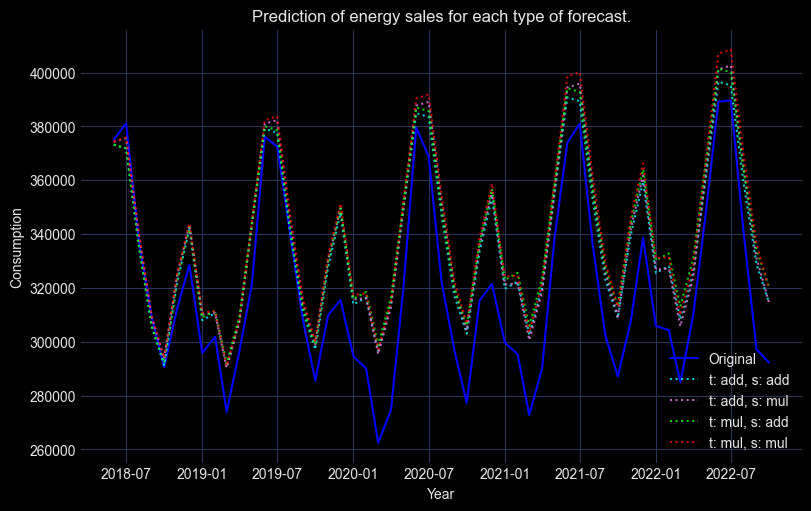

In [11]:
fig4, ax4 = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
ax4.plot(data_test.index, data_test['All sectors [MkWh]'], color=colors[-1], label='Original')
for color, ((trend, season), prediction) in zip(colors, predictions.items()):
    ax4.plot(data_test.index, prediction, color=color, 
             label=f't: {trend}, s: {season}', linestyle=':', alpha=0.8)
ax4.legend()
ax4.set(title='Prediction of energy sales for each type of forecast.',
        xlabel='Year', ylabel='Consumption')
ax4.set_facecolor('black')
fig4.set_facecolor('black')
fig4.savefig('./images/HoltWintersMethod4.png');

We can see that all types of forecasting perform very well. Now let's calculate errors:

* MAE

In [12]:
original = data_test['All sectors [MkWh]']
for (trend, season), prediction in predictions.items():
    error = mean_absolute_error(original, prediction)
    print(f'Trend: {trend}, Season: {season}, MAE: {error}')

Trend: add, Season: add, MAE: 17310.71403679682
Trend: add, Season: mul, MAE: 18814.137359624638
Trend: mul, Season: add, MAE: 19992.9736031298
Trend: mul, Season: mul, MAE: 21416.110240794675


* MSE

In [13]:
for (trend, season), prediction in predictions.items():
    error = mean_squared_error(original, prediction)
    print(f'Trend: {trend}, Season: {season}, MSE: {error}')

Trend: add, Season: add, MSE: 396810051.0776921
Trend: add, Season: mul, MSE: 444244864.99051774
Trend: mul, Season: add, MSE: 514202741.5909806
Trend: mul, Season: mul, MSE: 565036905.3492332


* Mean absolute scaled error (MASE)

In [14]:
def mean_absolute_scaled_error(actual, predicted):
    num_of_predictions = len(actual)
    nominator = np.abs(actual - predicted).sum() / num_of_predictions
    denominator = np.abs(actual[1:] - actual[:-1]).sum() / num_of_predictions-1
    return nominator / denominator

In [15]:
for (trend, season), prediction in predictions.items():
    error = mean_absolute_scaled_error(original, prediction)
    print(f'Trend: {trend}, Season: {season}, MASE: {error}')

Trend: add, Season: add, MASE: -17310.71403679682
Trend: add, Season: mul, MASE: -18814.137359624638
Trend: mul, Season: add, MASE: -19992.9736031298
Trend: mul, Season: mul, MASE: -21416.110240794675


* Forecast Bias (FB)

In [16]:
def forecast_bias(actual, predicted):
    return predicted.sum() - (actual_sum := actual.sum()) / actual_sum

In [17]:
for (trend, season), prediction in predictions.items():
    error = forecast_bias(original, prediction)
    print(f'Trend: {trend}, Season: {season}, FB: {error}')

Trend: add, Season: add, FB: 17823788.5003686
Trend: add, Season: mul, FB: 17923872.564170957
Trend: mul, Season: add, FB: 17966982.78227056
Trend: mul, Season: mul, FB: 18062519.266218703


This makes sense because all predictions are above real values.